In [3]:
import os
import sys

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
lib_paths = ['../src/', '../cifar-10.1-pytorch/', '../data-copying/', '../PyTorch_CIFAR10/']
for path in lib_paths:
    if os.path.abspath(path) not in sys.path:
        sys.path.insert(0, os.path.abspath(path))
print(sys.path)

['/nfs/home/cybai/PyTorch-StudioGAN/PyTorch_CIFAR10', '/nfs/home/cybai/PyTorch-StudioGAN/data-copying', '/nfs/home/cybai/PyTorch-StudioGAN/cifar-10.1-pytorch', '/nfs/home/cybai/PyTorch-StudioGAN/src', '/nfs/home/cybai/PyTorch-StudioGAN/notebooks', '/home/cybai/miniconda3/envs/studiogan/lib/python37.zip', '/home/cybai/miniconda3/envs/studiogan/lib/python3.7', '/home/cybai/miniconda3/envs/studiogan/lib/python3.7/lib-dynload', '', '/home/cybai/miniconda3/envs/studiogan/lib/python3.7/site-packages', '/home/cybai/miniconda3/envs/studiogan/lib/python3.7/site-packages/IPython/extensions', '/nfs/home/cybai/.ipython']


In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import functools
from importlib import reload
from matplotlib import pyplot as plt
import scipy
from scipy import stats
from scipy.special import softmax
import os
import ast
import glob

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import torch
from torch.nn import Parameter as P
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# import custom

import cifar10_models
reload(cifar10_models)

import cifar10_1
reload(cifar10_1)

from data_utils import cifair
reload(cifair)

from metrics.feat_extract_models import alexnet, inception, vgg
reload(alexnet)
reload(inception)
reload(vgg)

from utils import load_checkpoint
reload(load_checkpoint)

from metrics.FID import calculate_frechet_distance

import misc
reload(misc)

import data_copying_tests
reload(data_copying_tests)

from run_infos import runs

In [7]:
device = 'cuda'
torch.backends.cudnn.benchmark = True

In [8]:
cifar10_classnames = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'trucks']

In [9]:
cifar10_train_dset = datasets.CIFAR10('../data/cifar10', train=True, 
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(0.5, 0.5)]), 
                                      download=True) # range = [-1, 1]

Files already downloaded and verified


In [10]:
cifar10_train_dl = DataLoader(cifar10_train_dset, batch_size=50, shuffle=False, num_workers=8, drop_last=False)

In [11]:
proj_model = inception.WrappedInception3().eval().to(device)

##### trainable parameters

#####


In [12]:
(train_xs, train_ys), train_feats, _ = misc.project(cifar10_train_dl, proj_model, n_samples=None, to_numpy=True)
del _

In [13]:
nnds = misc.calculate_knnd_numpy(train_feats, train_feats, k=2, return_indices=False)

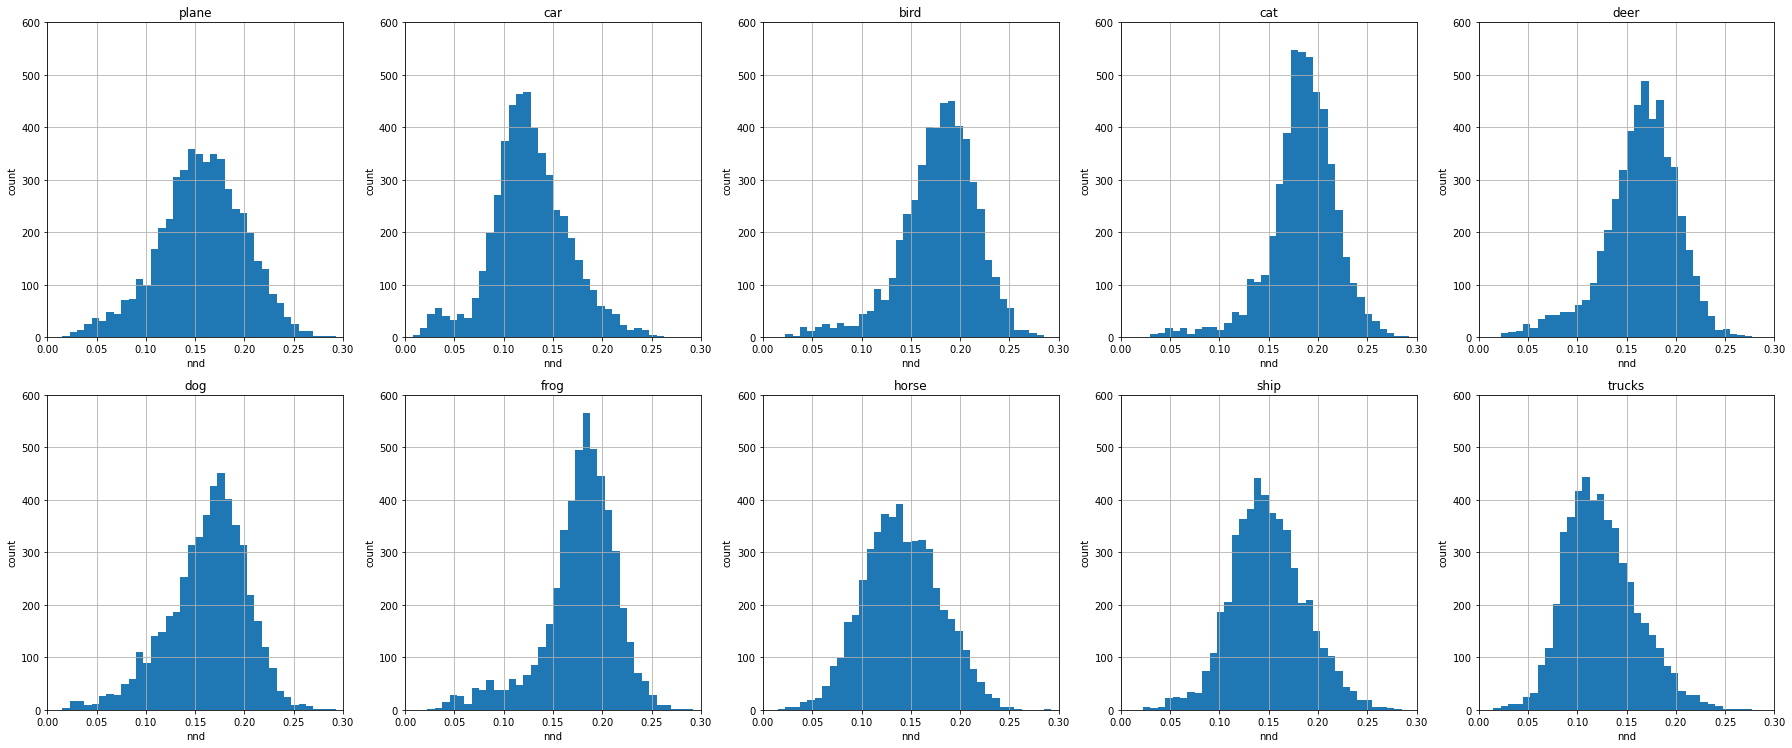

In [40]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10.5))
bins = np.arange(0, 0.3, 0.3 / 40)
for i, ax in enumerate(axs.flat):
    ax.hist(nnds[train_ys == i], bins=bins)
    ax.set_title(cifar10_classnames[i])
    ax.set_xlim(0, 0.3)
    ax.set_ylim(0, 600)
    ax.set_xlabel('nnd')
    ax.set_ylabel('count')
    ax.grid()
fig.tight_layout()
plt.savefig('cifar10_train_class_nnd_distr.pdf', bbox_inches='tight')

In [11]:
biggan_runs = {
    0: 'BigGAN-train-2021_04_03_21_38_59',
    0.13: 'BigGAN-train-2021_04_06_13_59_20',
    0.16: 'BigGAN-train-2021_04_06_14_00_18'
}

In [12]:
all_samplers = {mrt: misc.wrapper_all(runname, 'CIFAR10', device=device) 
                for mrt, runname in biggan_runs.items()}

In [19]:
all_samplers[0].keys()

dict_keys([74000, 10000, 60000, 78000, 12000, 38000, 14000, 32000, 40000, 28000, 34000, 84000, 64000, 30000, 44000, 8000, 54000, 18000, 96000, 42000, 72000, 90000, 82000, 100000, 52000, 36000, 92000, 22000, 70000, 68000, 2000, 4000, 80000, 76000, 26000, 6000, 56000, 88000, 98000, 50000, 48000, 58000, 94000, 62000, 46000, 24000, 66000, 16000, 86000, 20000])

In [35]:
ordered_epochs = np.arange(10000, 60000, 10000).astype(np.int)

In [36]:
for mrt, runname in biggan_runs.items():
    for epoch in ordered_epochs:
        sampler = all_samplers[mrt][epoch]
        build_cache(runname, sampler, cache_dir='/tmp2/cybai/studiogan/cache', 
                    conditional=True, which_epoch=epoch, proj_model=proj_model, verbose=True)

cache to /tmp2/cybai/studiogan/cache/BigGAN-train-2021_04_03_21_38_59/10000.npz
(50000, 3, 32, 32) (50000,) (50000, 2048)
cache to /tmp2/cybai/studiogan/cache/BigGAN-train-2021_04_03_21_38_59/20000.npz
(50000, 3, 32, 32) (50000,) (50000, 2048)
cache to /tmp2/cybai/studiogan/cache/BigGAN-train-2021_04_03_21_38_59/30000.npz
(50000, 3, 32, 32) (50000,) (50000, 2048)
cache to /tmp2/cybai/studiogan/cache/BigGAN-train-2021_04_03_21_38_59/40000.npz
(50000, 3, 32, 32) (50000,) (50000, 2048)
cache to /tmp2/cybai/studiogan/cache/BigGAN-train-2021_04_03_21_38_59/50000.npz
(50000, 3, 32, 32) (50000,) (50000, 2048)
cache to /tmp2/cybai/studiogan/cache/BigGAN-train-2021_04_06_13_59_20/10000.npz
(50000, 3, 32, 32) (50000,) (50000, 2048)
cache to /tmp2/cybai/studiogan/cache/BigGAN-train-2021_04_06_13_59_20/20000.npz
(50000, 3, 32, 32) (50000,) (50000, 2048)
cache to /tmp2/cybai/studiogan/cache/BigGAN-train-2021_04_06_13_59_20/30000.npz
(50000, 3, 32, 32) (50000,) (50000, 2048)
cache to /tmp2/cybai/stu

In [162]:
epoch = 100000
for mrt, runname in biggan_runs.items():
    sampler = all_samplers[mrt][epoch]
    build_cache(runname, sampler, cache_dir='/tmp2/cybai/studiogan/cache', 
                conditional=True, which_epoch=epoch, proj_model=proj_model, verbose=True)

cache to /tmp2/cybai/studiogan/cache/BigGAN-train-2021_04_03_21_38_59/100000.npz
(50000, 3, 32, 32) (50000,) (50000, 2048)
cache to /tmp2/cybai/studiogan/cache/BigGAN-train-2021_04_06_13_59_20/100000.npz
(50000, 3, 32, 32) (50000,) (50000, 2048)
cache to /tmp2/cybai/studiogan/cache/BigGAN-train-2021_04_06_14_00_18/100000.npz
(50000, 3, 32, 32) (50000,) (50000, 2048)


In [14]:
len(glob.glob(f'../checkpoints/BigGAN-train-2021_04_03_21_38_59/model=G_ema-weights-step=*.pth'))

50

In [61]:
all_nnd_infos = {}

In [64]:
for mrt, runname in tqdm(biggan_runs.items()):
    if mrt in all_nnd_infos:
        continue
    samplers = misc.wrapper_all(runname)
    
    nnd_infos = {}
    for epoch in tqdm(ordered_epochs):
        _, gen_feat, _ = misc.project(samplers[epoch], proj_model, n_samples=train_feats.shape[0], 
                                      to_numpy=True, return_logits=True)
        del _
        nnds = misc.calculate_knnd_numpy(target_feats=gen_feat, ref_feats=train_feats, return_indices=False)
        rev_nnds = misc.calculate_knnd_numpy(target_feats=train_feats, ref_feats=gen_feat, return_indices=False)

        nnd_infos[epoch] = {'pos': nnds, 'rev': rev_nnds}
    
    all_nnd_infos[mrt] = nnd_infos

100%|██████████| 3/3 [1:11:17<00:00, 1425.69s/it]


In [133]:
def plot_binnd_distr(nnd_infos, save_figname=None):
    fig, axs = plt.subplots(2, 5, figsize=(40, 16))

    bins = np.arange(0, 0.35, 0.35 / 70)

    for ax, (epoch, nnd_info) in zip(axs.flat, nnd_infos.items()):

        ax.hist(nnd_info['pos'], bins=bins, alpha=0.6, label='gen->train')
        ax.hist(nnd_info['rev'], bins=bins, alpha=0.6, label='train->gen')

        for q in np.quantile(nnd_info['pos'], np.arange(0.1, 1, 0.1)):
            ax.axvline(q, color='tab:blue')
            # print(q)
        ax.set_xlim(0, 0.35)
        ax.set_ylim(0, 3500)
        ax.grid()
        ax.legend()
        ax.set_xlabel('nnd')
        ax.set_ylabel('count')
        ax.set_title(f'epoch={epoch}')
        
    if save_figname is not None:
        plt.savefig(save_figname, bbox_inches='tight')

def plot_intrarun_nnd_distr(nnd_infos, save_figname=None):
    intervals = 80
    bins = np.arange(0.05, 0.3 + 0.25 / intervals, 0.25 / intervals)
    plt.figure(figsize=(8, 6.4))
    for epoch, nnd_info in nnd_infos.items():
        hist, bin_edges = np.histogram(nnd_info['pos'], bins=bins)
        plt.plot(bin_edges[:-1], hist, label=f"epoch={epoch}")
    plt.legend()
    plt.grid()
    plt.xlabel('nnd')
    plt.ylabel('count')
    plt.xlim(0.04, 0.31)
    plt.ylim(-100, 2300)
    
    if save_figname is not None:
        plt.savefig(save_figname, bbox_inches='tight')

def plot_interrun_nnd_distr(all_nnd_infos, save_figname=None):
    intervals = 80
    bins = np.arange(0.05, 0.3 + 0.25 / intervals, 0.25 / intervals)
    fig, axs = plt.subplots(2, 5, figsize=(32, 12.8))
    
    for mrt in sorted(list(all_nnd_infos.keys())):
        nnd_infos = all_nnd_infos[mrt]
        for ax, (epoch, nnd_info) in zip(axs.flat, nnd_infos.items()):
            hist, bin_edges = np.histogram(nnd_info['pos'], bins=bins)
            ax.plot(bin_edges[:-1], hist, label=f"mrt={mrt}")
            
    for ax, epoch in zip(axs.flat, nnd_infos.keys()):
        ax.legend()
        ax.grid()
        ax.set_title(f"epoch={epoch}")
        ax.set_xlabel('nnd')
        ax.set_ylabel('count')
        ax.set_xlim(0.04, 0.31)
        ax.set_ylim(-100, 2300)
    
    if save_figname is not None:
        plt.savefig(save_figname, bbox_inches='tight')

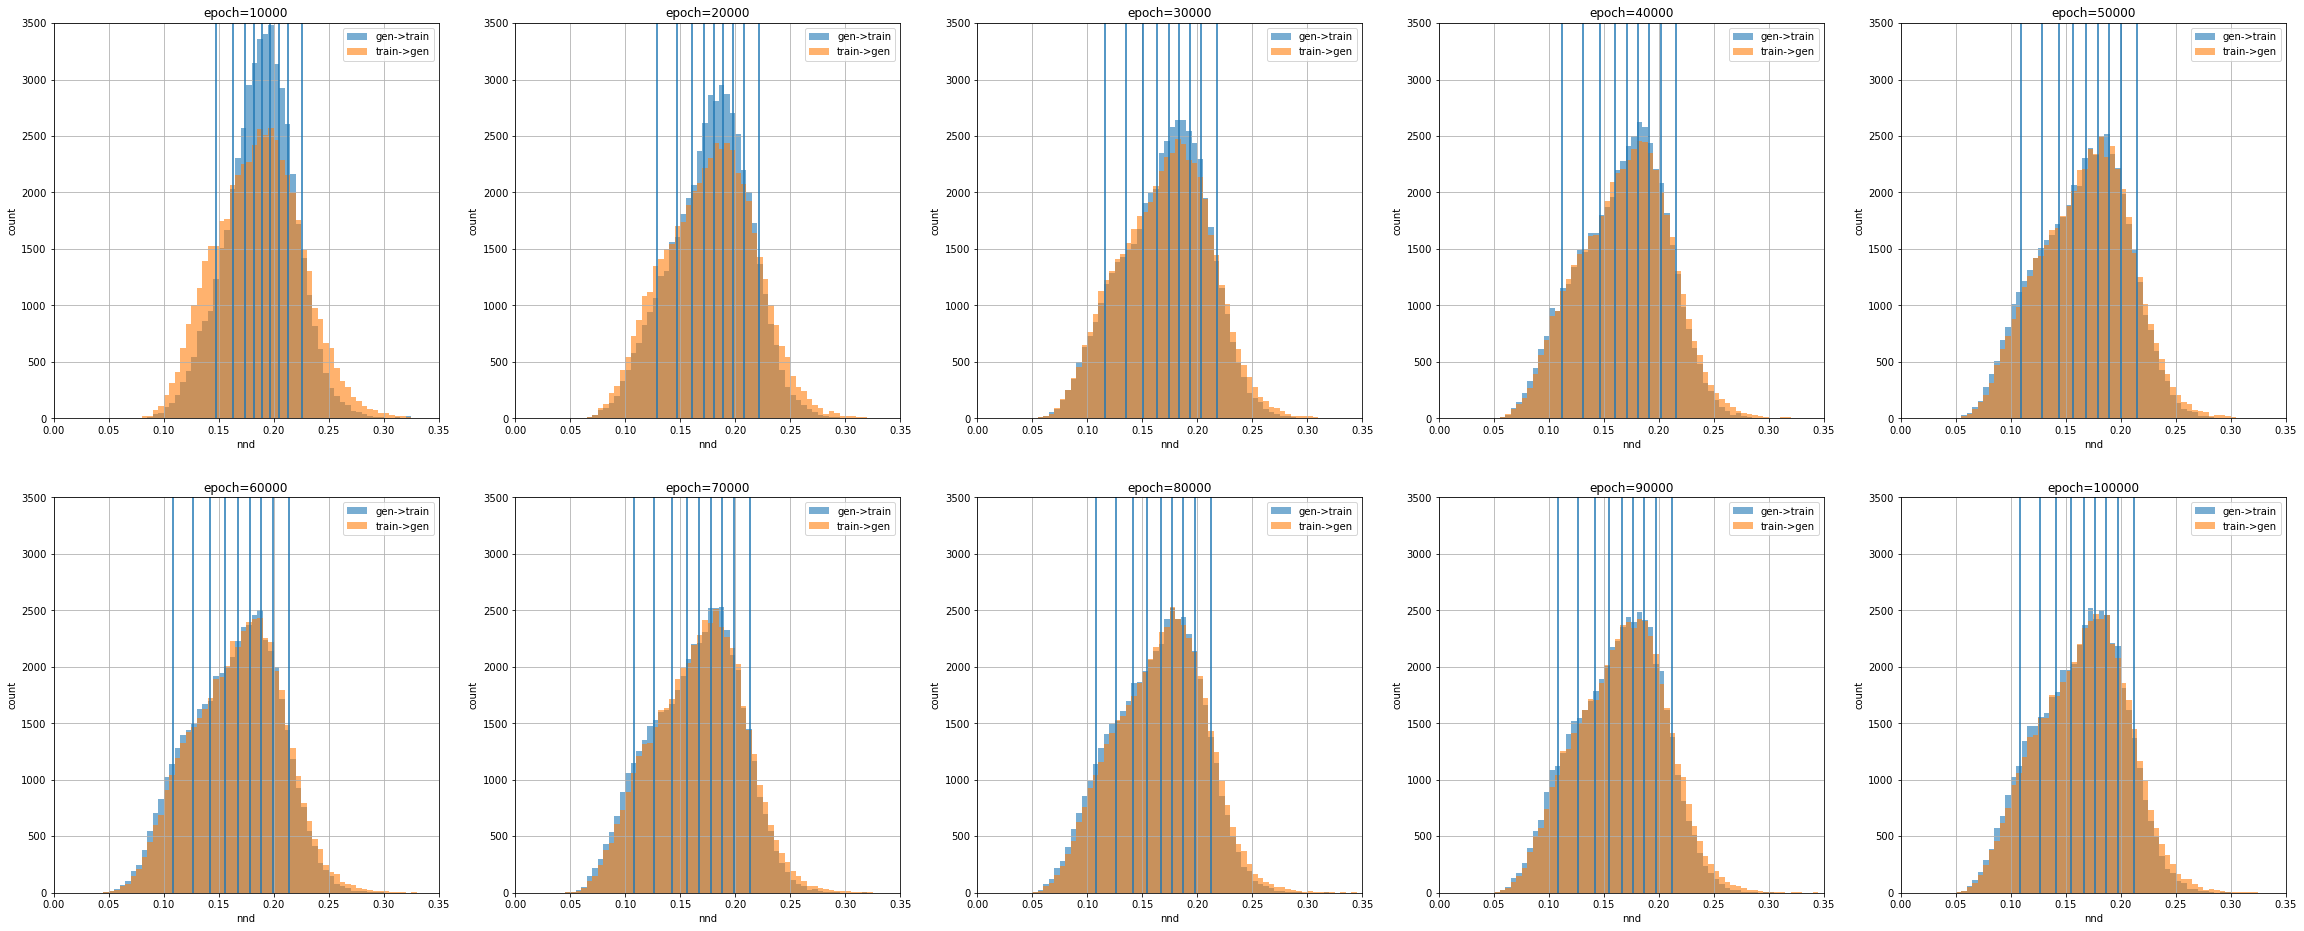

In [139]:
# mrt = 0
plot_binnd_distr(all_nnd_infos[0], "binnd_distr(mrt=0).pdf")

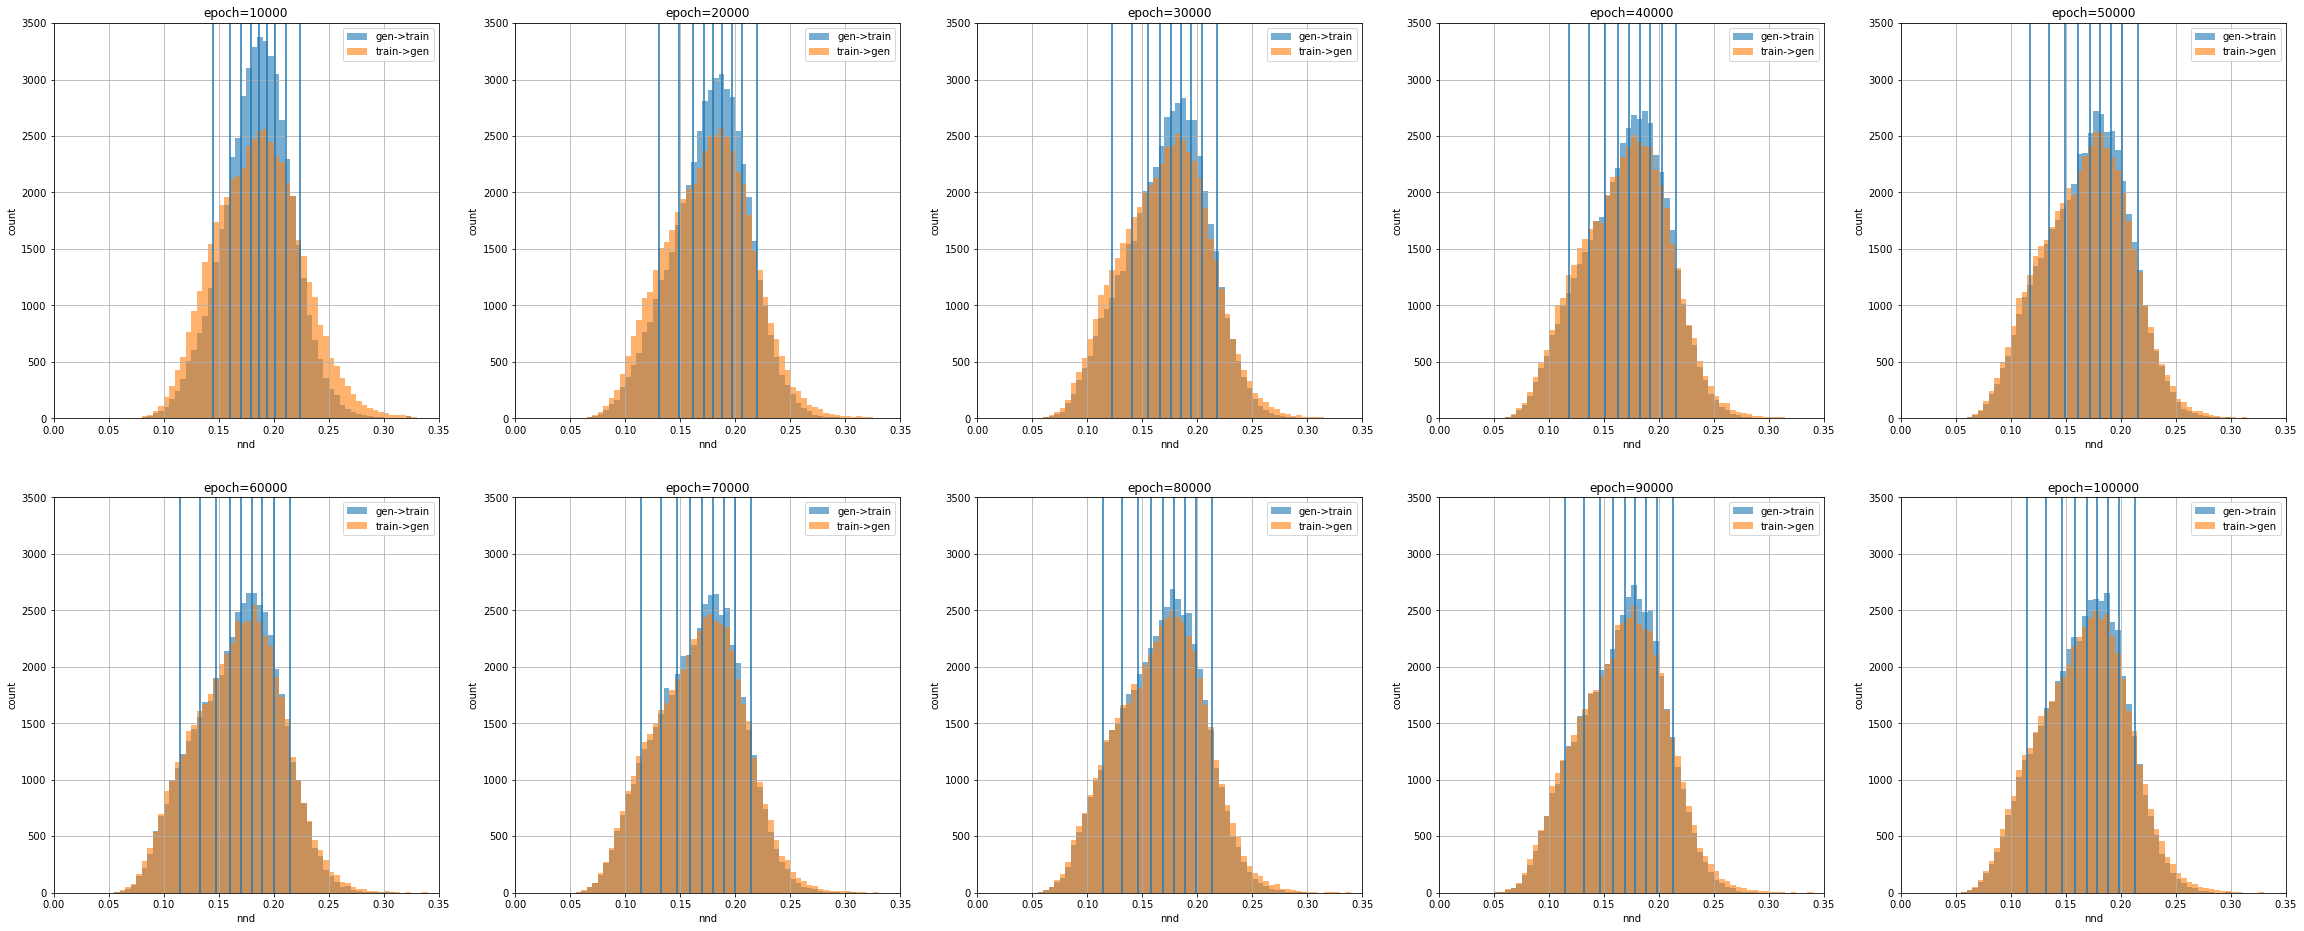

In [140]:
# mrt = 0.13
plot_binnd_distr(all_nnd_infos[0.13], "binnd_distr(mrt=0.13).pdf")

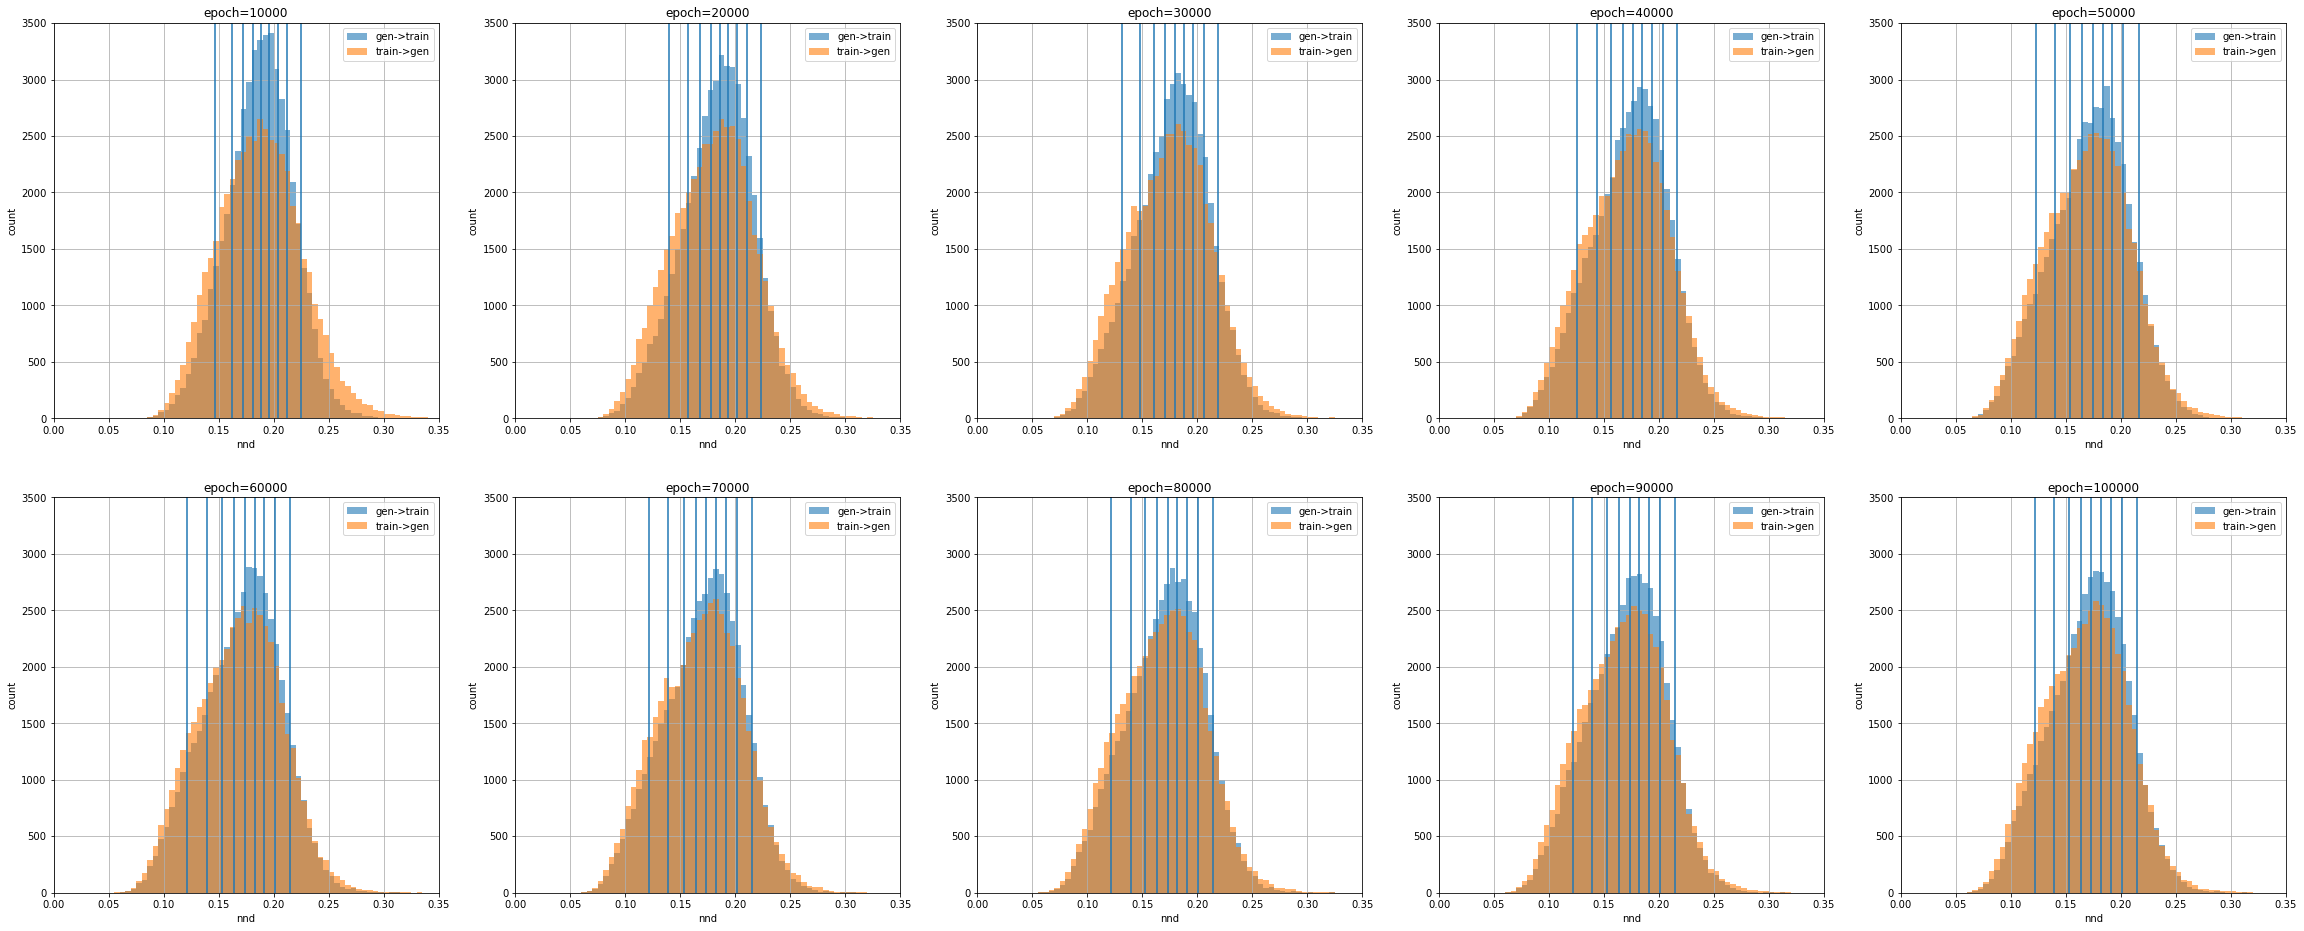

In [141]:
# mrt = 0.16
plot_binnd_distr(all_nnd_infos[0.16], "binnd_distr(mrt=0.16).pdf")

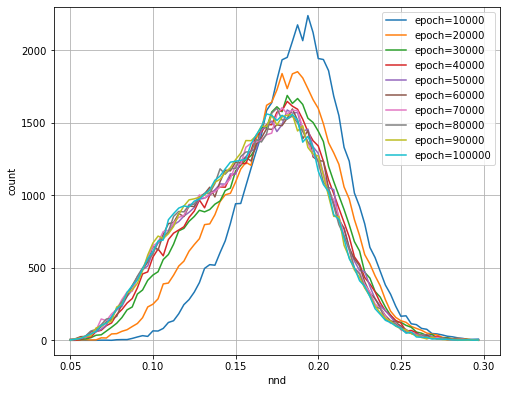

In [137]:
plot_intrarun_nnd_distr(all_nnd_infos[0], "intrarun_nnd_distr(mrt=0).pdf")

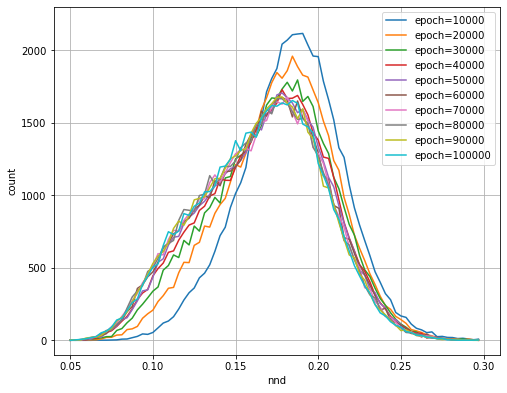

In [136]:
plot_intrarun_nnd_distr(all_nnd_infos[0.13], "intrarun_nnd_distr(mrt=0.13).pdf")

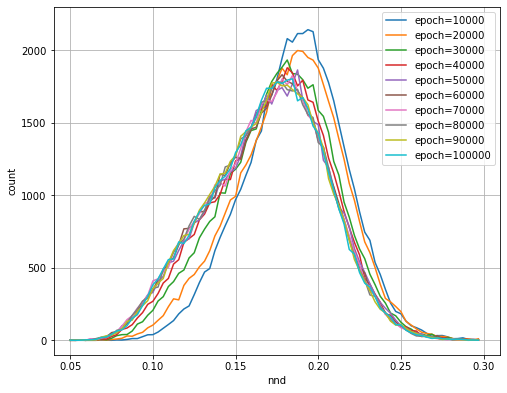

In [135]:
plot_intrarun_nnd_distr(all_nnd_infos[0.16], "intrarun_nnd_distr(mrt=0.16).pdf")

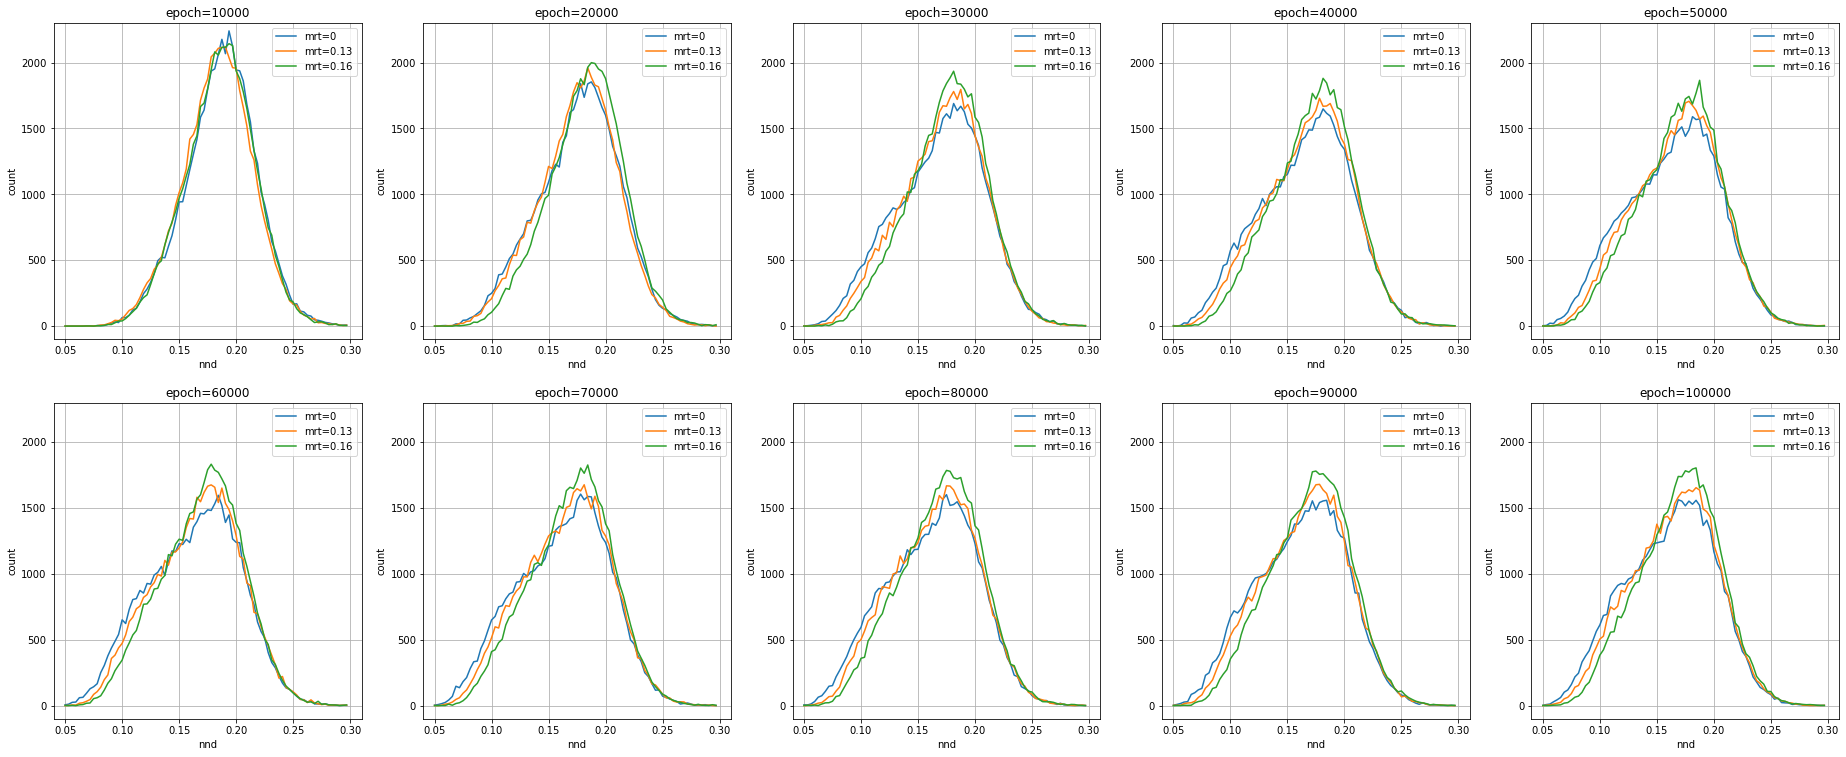

In [134]:
plot_interrun_nnd_distr(all_nnd_infos, "interrun_nnd_distr.pdf")

### Try to do tSNE

###### Same run across epochs

In [61]:
mrt = 0
gen_ys = {}
gen_feats = {}
nnd_indices = {}

for epoch in ordered_epochs:
    print(f"Processing epoch = {epoch}...")
    cache_path = os.path.join('/tmp2/cybai/studiogan/cache', biggan_runs[mrt], f"{epoch}.npz")
    gen_feats[epoch] = np.load(cache_path)['WrappedInception3']
    gen_ys[epoch] = np.load(cache_path)['Y']
    
    nnds_, nnd_indices_ = misc.calculate_knnd_numpy(target_feats=gen_feats[epoch], 
                                                    ref_feats=train_feats, return_indices=True)
    nnd_indices[epoch] = nnd_indices_

Processing epoch = 10000...
Processing epoch = 20000...
Processing epoch = 30000...
Processing epoch = 40000...
Processing epoch = 50000...


[ 5015 38348  5867 35927 21387 15860 49346 26160 13960   938] [155 138 128 104  95  94  87  86  86  84]
[ 5015 15860  2428 41270 38348 13960 30998 11002 40097 36446] [91 79 77 74 72 61 51 48 48 46]
[22643 30998 15860 48145 40626 27814  6590 14300 49643 29350] [43 41 39 36 36 35 34 34 33 33]
[14300 46240 44488 14966 21375 16652 12917  3265 24426 49643] [55 51 49 35 32 32 31 30 30 29]
[14300 46240 44488 14966  7588 24426 22643 22068 29350 47509] [62 48 35 34 32 32 30 29 29 28]


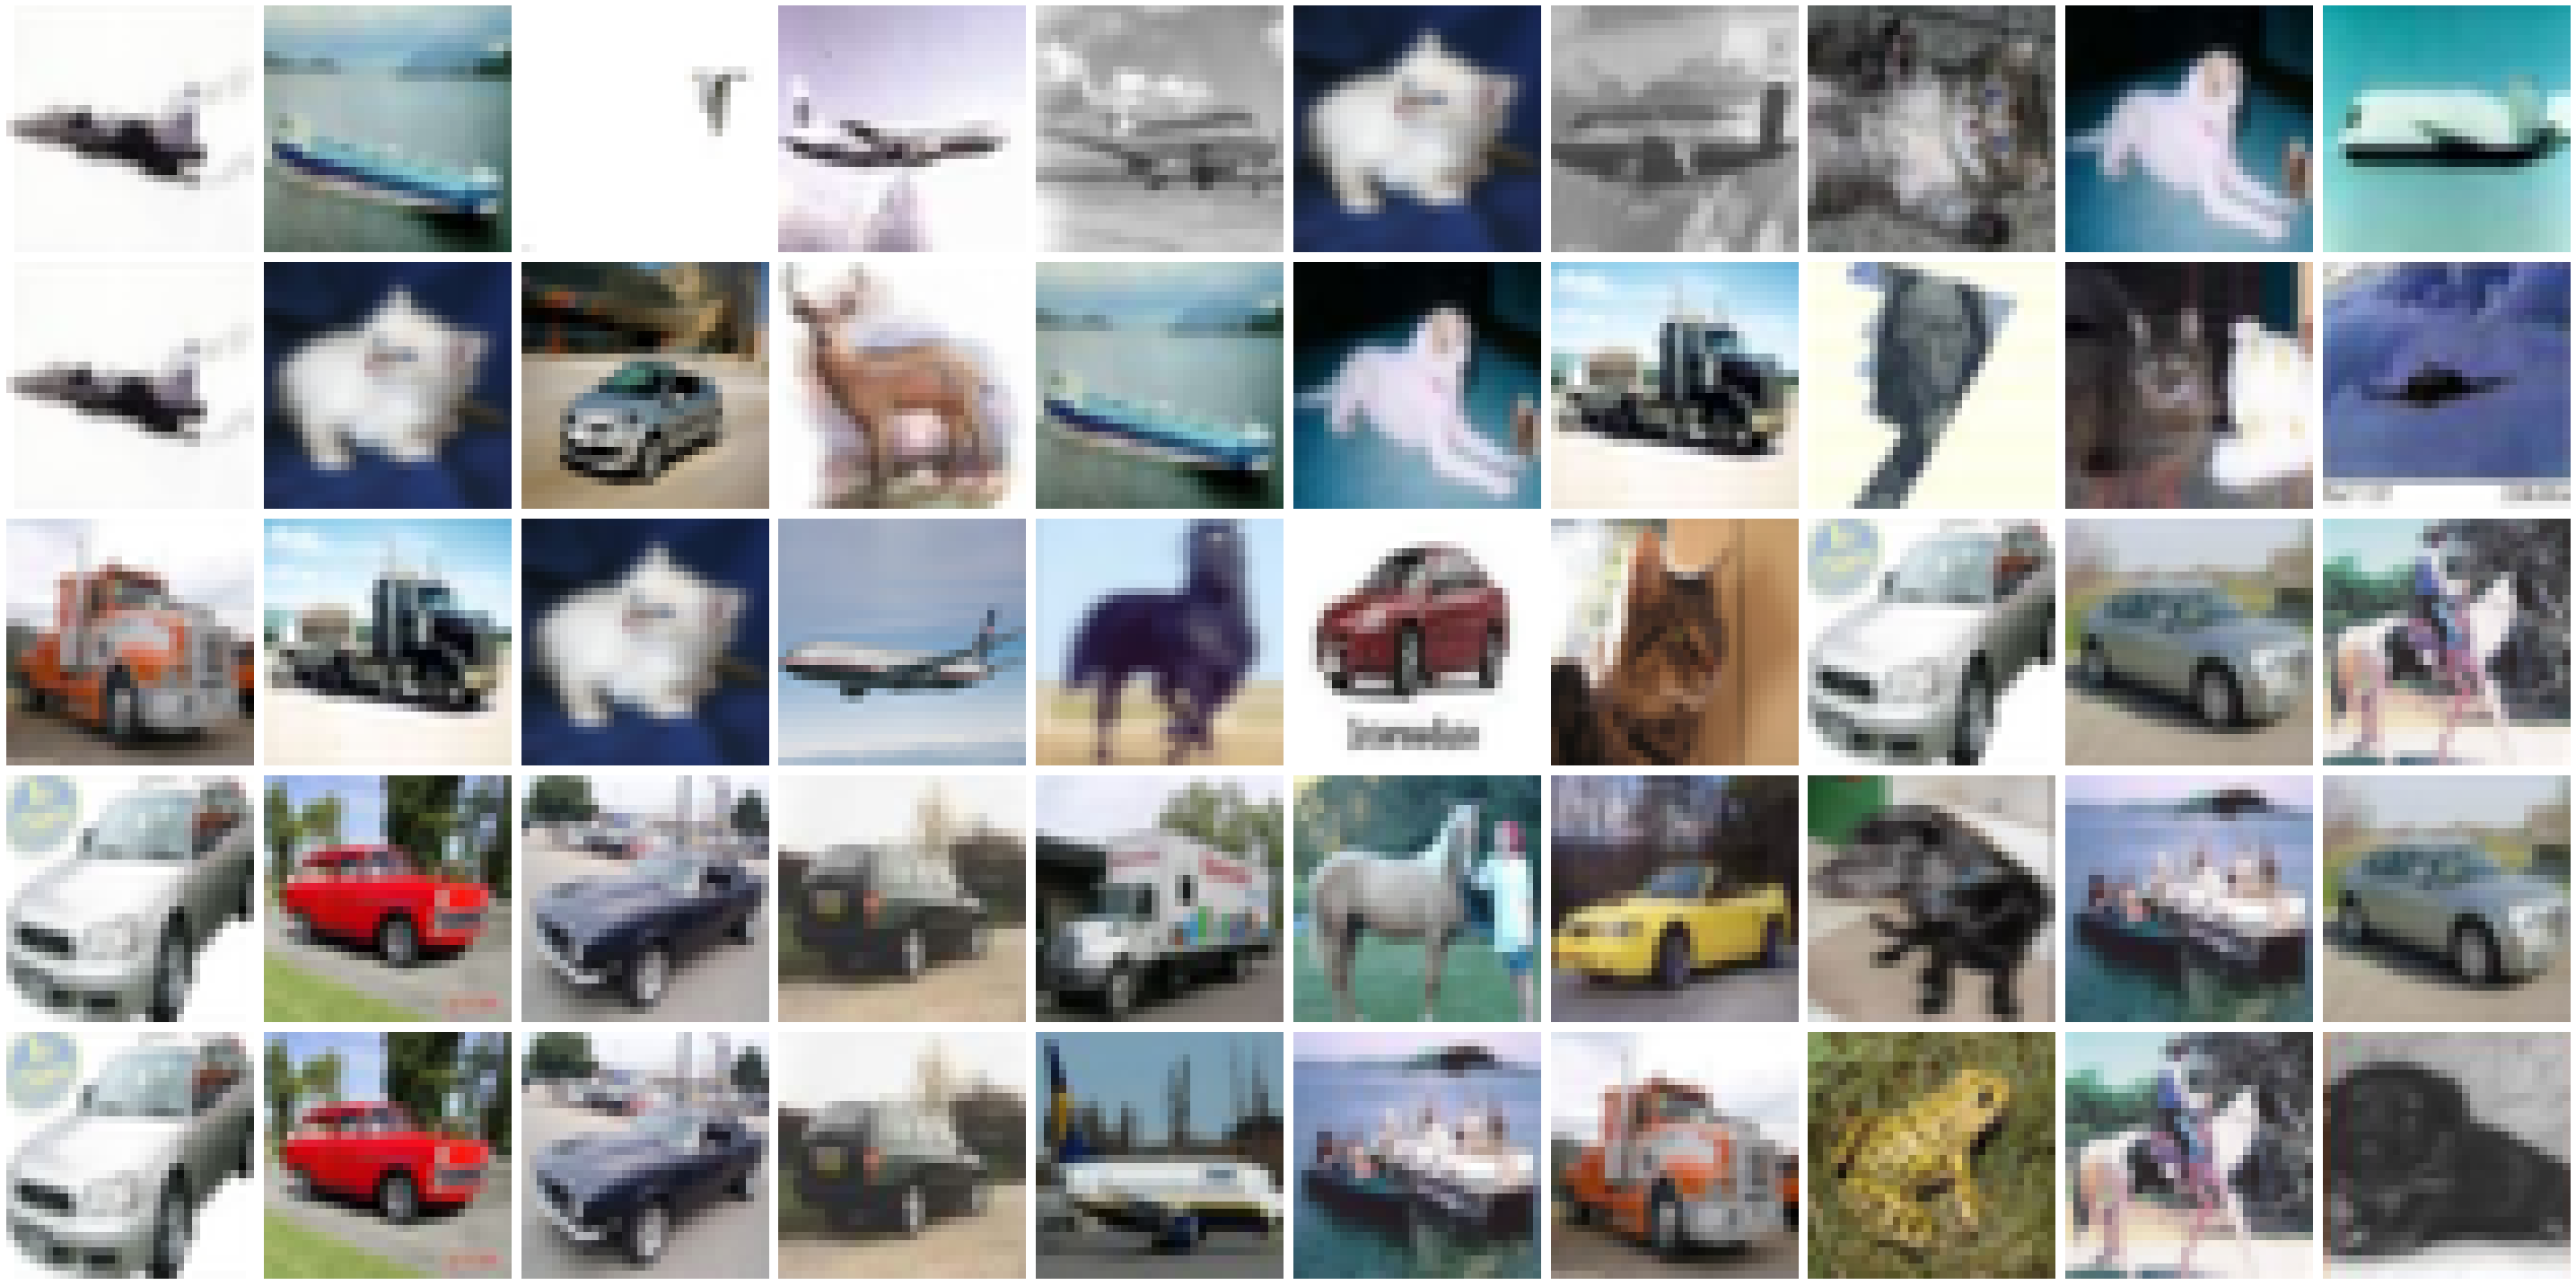

In [80]:
fig, axs = plt.subplots(5, 10, figsize=(40, 20))
for i, ((epoch, nnd_indices_), axs_) in enumerate(zip(nnd_indices.items(), axs)):
    indices, counts = np.unique(nnd_indices_, return_counts=True)
    top5_indices = np.argsort(-counts)[:10]
    print(indices[top5_indices], counts[top5_indices])
    for idx, ax in zip(indices[top5_indices], axs_):
        img = cifar10_train_dset[idx][0].detach().cpu().numpy()
        ax.imshow((np.transpose(img, (1, 2, 0)) + 1.) / 2.)
        ax.axis('off')
fig.tight_layout()

In [113]:
tsne = TSNE(n_jobs=-1)

In [115]:
n_samples = 500

In [116]:
all_gen_car_feats = np.concatenate([gen_feats[epoch][gen_ys[epoch] == 1][:n_samples] 
                                    for epoch in ordered_epochs], axis=0)
all_gen_car_feats.shape

(2500, 2048)

In [117]:
train_car_feats = train_feats[train_ys == 1][:500]

In [118]:
car_tsnes = tsne.fit_transform(np.concatenate([train_car_feats, all_gen_car_feats], axis=0))
car_tsnes.shape

(3000, 2)

In [119]:
n = 0
train_car_tsnes = car_tsnes[:n_samples]
n += n_samples
gen_car_tsnes = {}
for epoch in ordered_epochs:
    gen_car_tsnes[epoch] = car_tsnes[n:n + n_samples]
    n += n_samples

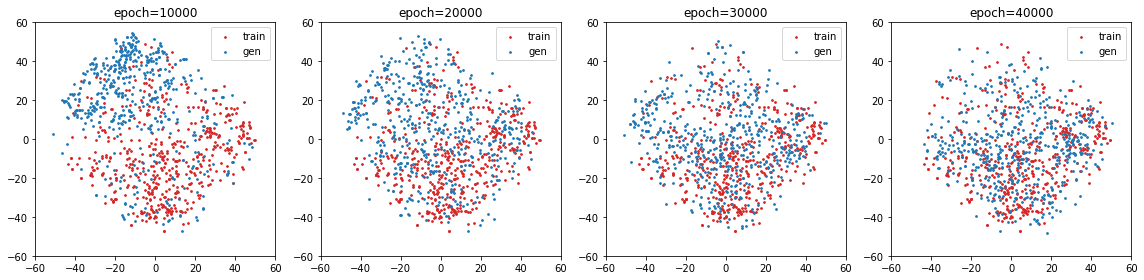

In [136]:
fig, axs= plt.subplots(1, 4, figsize=(16, 4))

for ax, (epoch, gen_car_tsne) in zip(axs.flat, gen_car_tsnes.items()):
    ax.scatter(train_car_tsnes[:, 0], train_car_tsnes[:, 1], 
                s=3, label='train', color='tab:red')
    ax.scatter(gen_car_tsne[:, 0], gen_car_tsne[:, 1], s=3, 
               label='gen', color='tab:blue')

    boundary = 60

    ax.set_title(f'epoch={epoch}')
    ax.legend()
    ax.set_xlim(-boundary, boundary)
    ax.set_ylim(-boundary, boundary)
fig.tight_layout()
plt.savefig(f'nnd_distr_tsne(mrt={mrt}).pdf', bbox_inches='tight')

###### Same epoch across mrts

In [163]:
epoch = 100000

gen_ys = {}
gen_feats = {}
nnd_indices = {}

for mrt in biggan_runs.keys():
    print(f"Processing mrt = {mrt}...")
    cache_path = os.path.join('/tmp2/cybai/studiogan/cache', biggan_runs[mrt], f"{epoch}.npz")
    gen_feats[mrt] = np.load(cache_path)['WrappedInception3']
    gen_ys[mrt] = np.load(cache_path)['Y']
    
    nnds_, nnd_indices_ = misc.calculate_knnd_numpy(target_feats=gen_feats[mrt], 
                                                    ref_feats=train_feats, return_indices=True)
    nnd_indices[mrt] = nnd_indices_

Processing mrt = 0...
Processing mrt = 0.13...
Processing mrt = 0.16...


In [164]:
tsne = TSNE(n_jobs=-1)

In [165]:
n_samples = 1000

In [166]:
all_gen_car_feats = np.concatenate([gen_feats[mrt][gen_ys[mrt] == 1][:n_samples] 
                                    for mrt in biggan_runs.keys()], axis=0)
print(all_gen_car_feats.shape)

train_car_feats = train_feats[train_ys == 1][:500]
print(train_car_feats.shape)

(3000, 2048)
(500, 2048)


In [167]:
car_tsnes = tsne.fit_transform(np.concatenate([train_car_feats, all_gen_car_feats], axis=0))
car_tsnes.shape

(3500, 2)

In [168]:
n = 0
train_car_tsnes = car_tsnes[:n_samples]
n += n_samples
gen_car_tsnes = {}
for mrt in biggan_runs.keys():
    gen_car_tsnes[mrt] = car_tsnes[n:n + n_samples]
    n += n_samples

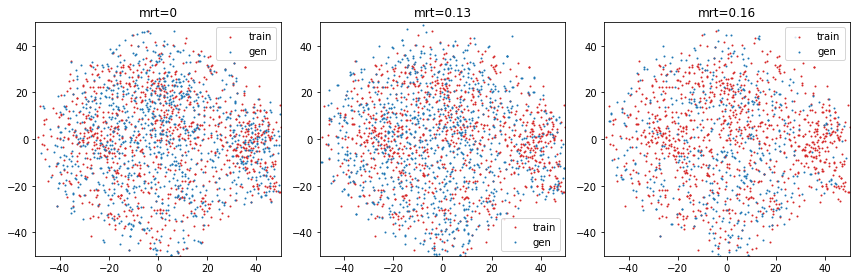

In [169]:
fig, axs= plt.subplots(1, 3, figsize=(12, 4))

for ax, (mrt, gen_car_tsne) in zip(axs.flat, gen_car_tsnes.items()):
    ax.scatter(train_car_tsnes[:, 0], train_car_tsnes[:, 1], 
                s=1, label='train', color='tab:red')
    ax.scatter(gen_car_tsne[:, 0], gen_car_tsne[:, 1], s=1, 
               label='gen', color='tab:blue')

    boundary = 50

    ax.set_title(f'mrt={mrt}')
    ax.legend()
    ax.set_xlim(-boundary, boundary)
    ax.set_ylim(-boundary, boundary)
fig.tight_layout()

plt.savefig(f'nnd_distr_tsne_intrarun(epoch={epoch}).pdf', bbox_inches='tight')

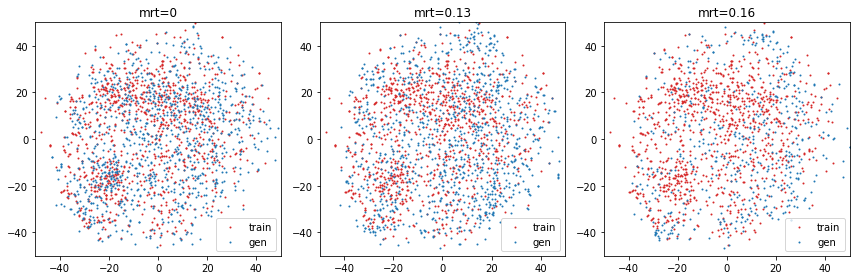

In [160]:
# epoch=40000

### Label different bins of mrt

In [12]:
runs['CIFAR10']['diffaug'][0.00][0]

'DiffAugGAN(P)-train-2021_03_06_20_15_56'

In [14]:
with np.load(os.path.join('/tmp2/cybai/studiogan/cache/', runs['CIFAR10']['diffaug'][0.00][0],
                          'best.npz')) as f:
    xs, ys, feats = f['X'], f['Y'], f['WrappedInception3']

In [23]:
nnds = misc.calculate_knnd_numpy(target_feats=feats, 
                                 ref_feats=train_feats, return_indices=False)

In [47]:
tsne = TSNE(n_jobs=-1)

In [48]:
all_tsnes = tsne.fit_transform(np.concatenate([feats, train_feats], axis=0))
all_tsnes.shape
'''
car_tsnes = tsne.fit_transform(np.concatenate([class_feats,
                                               train_feats[train_ys == cifar10_classnames.index(target_class)]], axis=0))
car_tsnes.shape
'''

'\ncar_tsnes = tsne.fit_transform(np.concatenate([class_feats,\n                                               train_feats[train_ys == cifar10_classnames.index(target_class)]], axis=0))\ncar_tsnes.shape\n'

In [49]:
if not os.path.isfile('all_tsnes.npy'):
    np.save('all_tsnes.npy', all_tsnes)

In [90]:
target_class = 'car'

class_mask = ys == cifar10_classnames.index(target_class)
class_xs, class_feats, class_nnds = xs[class_mask], feats[class_mask], nnds[class_mask]
bin_edges = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1]
hist_indices = np.digitize(class_nnds, bin_edges)
print(hist_indices.shape)

gen_class_tsnes = all_tsnes[:feats.shape[0]][class_mask]
train_class_tsnes = all_tsnes[feats.shape[0]:][train_ys == cifar10_classnames.index(target_class)]
print(gen_class_tsnes.shape, train_class_tsnes.shape)

(5078,)
(5078, 2) (5000, 2)


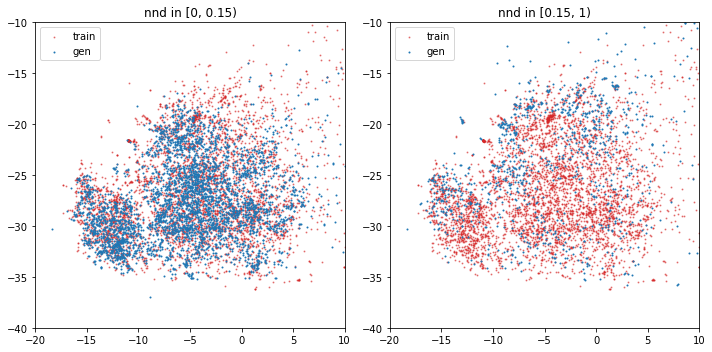

In [93]:
ts = [0, 0.15, 1] # 0.12793098

fig, axs = plt.subplots(1, len(ts) - 1, figsize=((len(ts) - 1) * 5, 5))

for i, ax in enumerate(axs.flat):
    ax.scatter(train_class_tsnes[:, 0], train_class_tsnes[:, 1], s=1, label='train', 
               color='tab:red', alpha=0.5)

    bin_mask = np.logical_and(class_nnds >= ts[i], class_nnds < ts[i + 1])
    ax.scatter(gen_class_tsnes[bin_mask][:, 0], gen_class_tsnes[bin_mask][:, 1], s=1, 
               label='gen', color='tab:blue')
    ax.set_title(f'nnd in [{ts[i]}, {ts[i + 1]})')

    ax.legend()
    ax.set_xlim(-20, 10)
    ax.set_ylim(-40, -10)
fig.tight_layout()
plt.savefig('nnd_tsne(cifar10_inceptionv3_car).pdf', bbox_inches='tight')

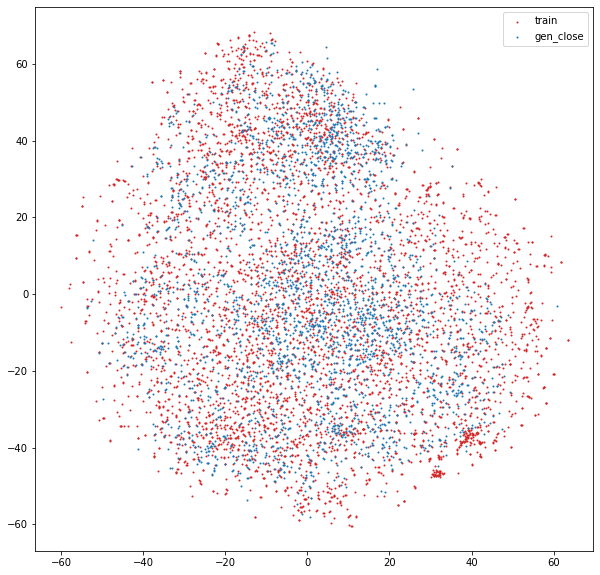